# Detección de Espacios de Estacionamiento en la Ciudad de Granada.
## Segmentación de Imágenes con técnicas de Deep Learning.
### Notebook 3.1: Modelo de Segmentación de Imágenes con DeepLabV3+.

### Autores:
- **Luis Crespo Orti**
- **Isabel María Moreno Cuadrado**
- **Pablo Olivares Martínez**
- **Ximo Sanz Tornero**


## 1. Importación de librerías y funciones.

In [ ]:
%pip install torch torchvision fastai segmentation-models-pytorch opencv-python

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Jan  8 16:14:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

Tesla T4
True


In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None:
        nrows = int(np.ceil(n / ncols))
    elif ncols is None:
        ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off()
           for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i ==
                0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [ ]:
# Function to save the metrics to a csv file
def save_metrics_to_csv(learner, file_path='deeplab_metrics.csv', **kwargs):
    recorder = learner.recorder
    metrics = np.stack(recorder.values)
    names = recorder.metric_names[1:-1]

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Escribir las cabeceras (nombres de las métricas)
        writer.writerow(['epoch'] + names)

        # Escribir las métricas por época
        for epoch, metric_values in enumerate(metrics):
            writer.writerow([epoch + 1] + list(metric_values))

    print(f"Metrics saved to {file_path}")

## 2. Carga y preparación de los datos.

In [ ]:
path_to_dataset = Path('/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train')

In [ ]:
def get_y_fn(x):
    """
    Dada la ruta de una imagen, devuelve la ruta de su máscara correspondiente.
    """
    return Path(str(x).replace('src', 'gt').replace('.JPG', '.png'))


def get_items(path):
    """
    Obtiene una lista de todas las imágenes en el directorio 'src'.
    """
    return get_image_files(path/'src')

In [ ]:
# Definición de la función para normalizar la máscara
def normalize_mask(mask, mapping):
    if mask.ndim != 3 or mask.shape[-1] != 3:
        raise ValueError(
            "La máscara debe ser una imagen RGB con 3 canales de color.")
    h, w, _ = mask.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, c in mapping.items():
        mask_class[(mask == color).all(axis=-1)] = c
    return mask_class

# Definición de la función para denormalizar la máscara
def denormalize_mask(mask_class, mapeo):
    inverse_map = {v: k for k, v in mapeo.items()}
    h, w = mask_class.shape
    mask_color = np.zeros((h, w, 3), dtype=np.uint8)
    for c in np.unique(mask_class):
        color = inverse_map[c]
        mask_color[mask_class == c] = color
    return mask_color


# Mapeo de color a clase para la normalización de máscaras
mapping_class_color = {
    (107, 142, 35): 0,  # Clase 0 - Background
    (102, 102, 156): 0,  # Clase 0
    (128, 64, 128): 1,  # Clase 1 - Road
    (0, 0, 142): 2,  # Clase 2 - Car
    (0, 0, 0): 0,     # Clase 0
}

# Función para obtener la máscara normalizada
def get_mask(item):
    msk_path = get_y_fn(item)
    msk = np.array(PILImage.create(msk_path))
    return PILMask.create(normalize_mask(msk, mapping_class_color))

In [ ]:
# Función para añadir sombras a las imágenes
def add_shadow(image, num_shadows, min_opacity, max_opacity):
    height, width = image.shape[:2]
    shadow_image = image.copy()

    for _ in range(num_shadows):
        # Randomly generate the shadow polygon
        x1, y1 = random.randint(0, width), random.randint(0, height)
        x2, y2 = random.randint(0, width), random.randint(0, height)
        x3, y3 = random.randint(0, width), random.randint(0, height)
        x4, y4 = random.randint(0, width), random.randint(0, height)

        # Create a black polygon to simulate the shadow
        poly = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)
        cv2.fillPoly(shadow_image, [poly], (0, 0, 0))

        # Blending the shadow with the image
        alpha = random.uniform(min_opacity, max_opacity)
        mask = shadow_image.astype(bool)
        shadow_image = cv2.addWeighted(shadow_image, alpha, image, 1 - alpha, 0, image)
        image[mask] = shadow_image[mask]

    return image

class ShadowTransform(Transform):
    """
    Custom Transform for adding shadows.
    """
    def __init__(self, num_shadows=3, min_opacity=0.5, max_opacity=0.75):
        self.num_shadows = num_shadows
        self.min_opacity = min_opacity
        self.max_opacity = max_opacity

    def encodes(self, x: PILImage):
        return add_shadow(x, self.num_shadows, self.min_opacity, self.max_opacity)

In [ ]:
# Transformaciones por defecto
aug_transforms = aug_transforms(mult=2, do_flip=True, flip_vert=True,
                                max_rotate=90., min_zoom=0.8, max_zoom=3.0,
                                max_lighting=0.2, max_warp=0.2, p_affine=0.75,
                                p_lighting=0.75, xtra_tfms=None, size=None,
                                mode='bilinear', pad_mode='reflection',
                                align_corners=True, batch=False, min_scale=1)

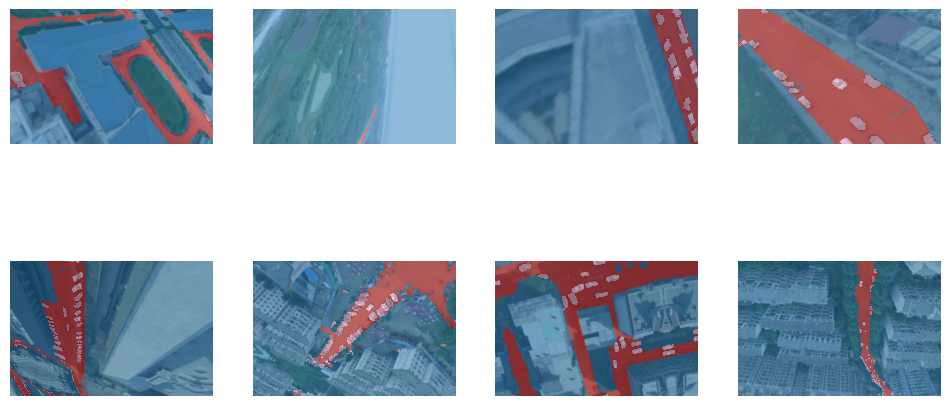

In [ ]:
# Definir el número de clases en tu conjunto de datos
num_classes = 3

# Definir el formato de los bloques de datos
data = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=np.arange(num_classes))),
    get_items=get_items,
    get_y=get_mask,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=Resize((256, 384)),
    batch_tfms=[*aug_transforms, ShadowTransform(
        num_shadows=3, min_opacity=0.5, max_opacity=0.75), Normalize.from_stats(*imagenet_stats)]
)

# Crea DataLoaders y muestra un lote de entrenamiento
dls = data.dataloaders(path_to_dataset, bs=32)
dls.train.show_batch(max_n=8)

In [ ]:
# Vemos la forma de un lote
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([32, 3, 256, 384]), torch.Size([32, 256, 384]))

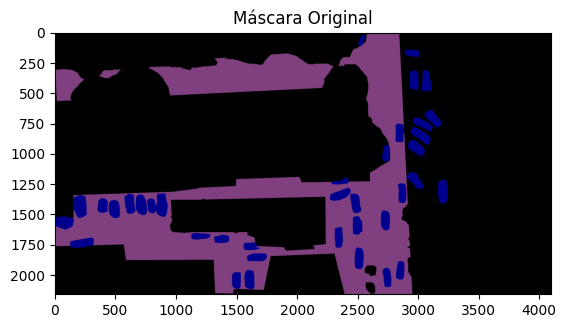

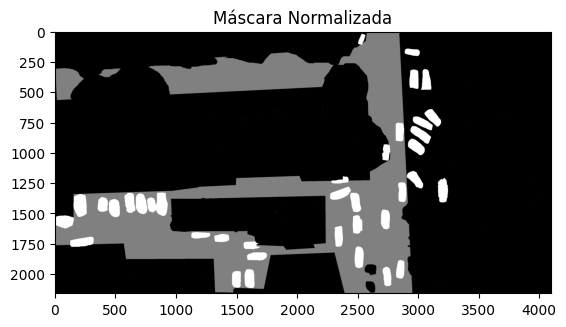

In [ ]:
path_to_image = '/content/drive/My Drive/images/UDD5_3C_AUGMENTED/train/src/001401.JPG'  # Cambia esto por una ruta real
mask_path = get_y_fn(path_to_image)

# Cargar la máscara original
original_mask = PILImage.create(mask_path)
plt.imshow(original_mask)
plt.title("Máscara Original")
plt.show()

# Aplicar normalización
normalized_mask = normalize_mask(np.array(original_mask), mapping_class_color)
plt.imshow(normalized_mask, cmap='gray')
plt.title("Máscara Normalizada")
plt.show()

## 3. Implementación del modelo.

In [1]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = num_classes
ACTIVATION = None

# Importamos el modelo DeepLabV3Plus
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)

NameError: name 'num_classes' is not defined

In [ ]:
# Crear un objeto de tipo Learner
learner = Learner(dls, model,loss_func=FocalLoss(), metrics=[foreground_acc, DiceMulti(), JaccardCoeffMulti()])

## 4. Entrenamiento del modelo.

In [ ]:
# Entrenar el modelo
learner.fit_one_cycle(60)   #En ejecución

epoch,train_loss,valid_loss,foreground_acc,dice_multi,jaccard_coeff_multi,time
0,0.848476,0.462217,0.081445,0.326119,0.279526,03:25
1,0.710763,0.608352,0.265923,0.302267,0.196083,03:23
2,0.590290,1.116385,0.116666,0.328736,0.269400,03:23
3,0.493252,0.633748,0.374917,0.462445,0.365267,03:20
4,0.412476,1.288909,0.455646,0.532539,0.440167,03:23
5,0.347263,0.492057,0.605231,0.550105,0.464226,03:27
6,0.296756,0.159474,0.539142,0.627096,0.516455,03:24
7,0.257810,0.217441,0.631822,0.594797,0.482164,03:22
8,0.228195,0.157589,0.522065,0.661714,0.537746,03:21
9,0.204950,0.104913,0.661090,0.687913,0.568144,03:25


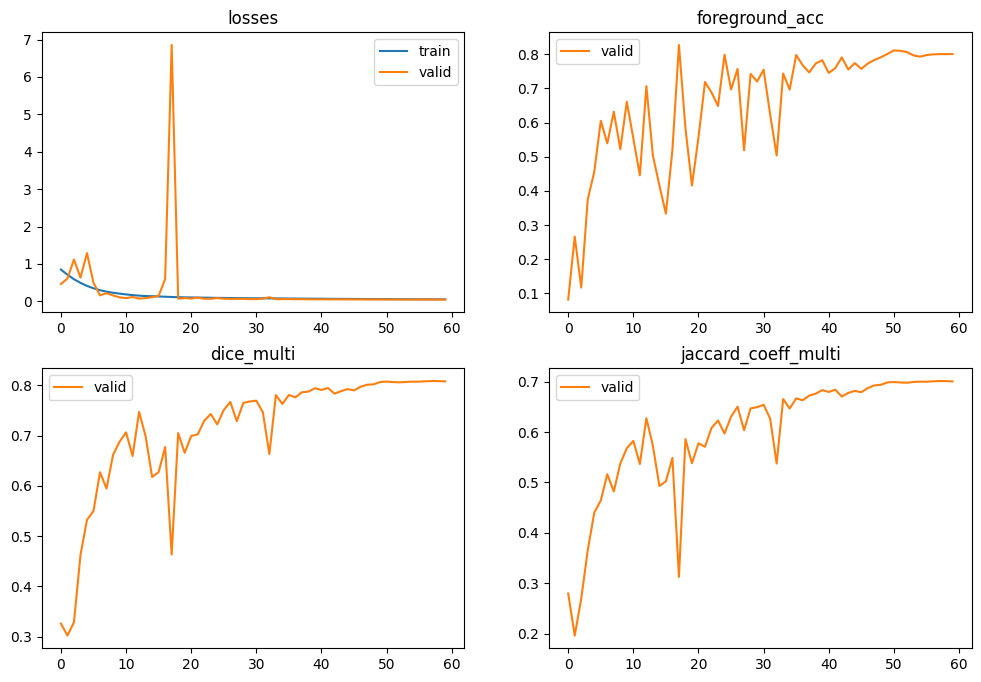

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
save_metrics_to_csv(learner, file_path='pspnet_metrics.csv')

Metrics saved to pspnet_metrics.csv


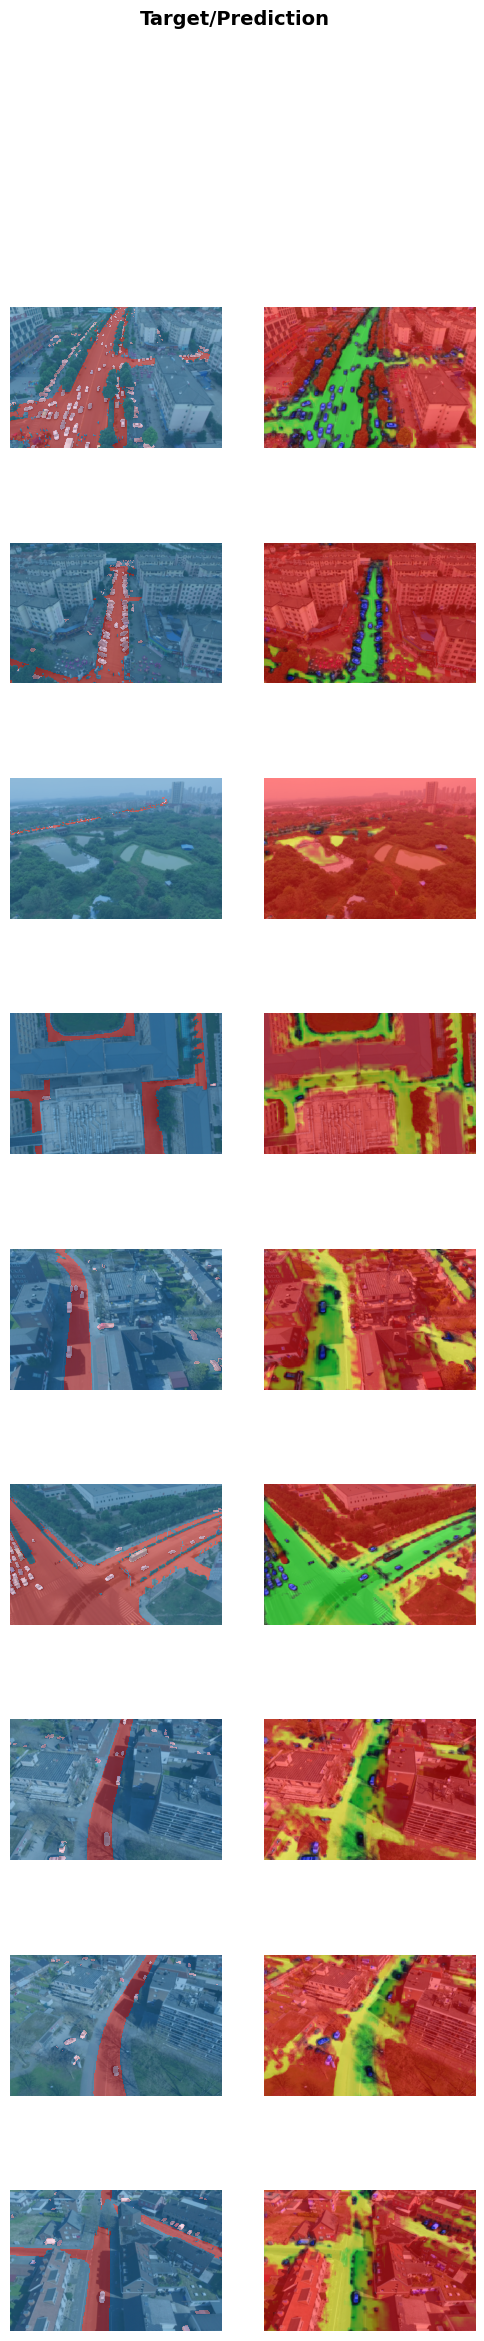

In [ ]:
learner.show_results()

## 5. Evaluación del modelo.

In [ ]:
# Preparar el conjunto de datos de prueba
path_test = Path('/media/HDD/Documentos/DGIIM5/UDD5_3C_AUGMENTED/val')
test_items = get_items(path_test)
test_dl = learner.dls.test_dl(test_items)

# Realizar predicciones
preds, _ = learner.get_preds(dl=test_dl)

IndexError: list index out of range

In [ ]:
# Visualizar los resultados
for i, (img, pred) in enumerate(zip(test_dl.items, preds)):
    original_image = PILImage.create(img)
    true_mask_path = get_y_fn(img)
    true_mask = PILImage.create(true_mask_path)
    predicted_mask = denormalize_mask(pred.argmax(dim=0).numpy(), mapping_class_color)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask)
    plt.title("Predicted Mask")

    plt.show()

In [ ]:
# Exportar los pesos del modelo
learner.export(fname='deeplab.pkl')